<span style='background:#DCEDC8; font-size:30px; display:block; border-left:40px solid #C5E1A5; padding-left:40px;'>
<b>
    Download multiple meteoscreening variables
</b>
</span>

**notebook version**: `2` (2 Mar 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Specify what you want to download in the `User settings`
- Data are stored to a `.csv` file in this folder
- The end of the notebook also shows how to format downloaded data for upload to `FLUXNET` for data sharing

# **User settings** (please adjust)

## Site

In [1]:
SITE='ch-fru'

## Variables to download
- Specify variables as shown in the database

In [2]:
# Variable names
# Variables are called FIELDS in the database; InfluxDB stores variable names as '_field'
FIELDS = [
    'G_GF1_0.03_1',
    'G_GF1_0.03_2'
]  

# Measurement names
# used to group similar variable together, e.g., 'TA' contains all air temperature variables
MEASUREMENTS = ['G']

## Time range to download
- `START`: Download data starting with this date (the start date itself IS included)
- `STOP`: Download data before this date (the stop date itself IS NOT included)

In [3]:
START = '2005-01-01 00:00:01'  
STOP = '2018-01-01 00:00:01'

## Output file
- Name of the output file that will contain the downloaded data

In [4]:
OUTFILE = f"CH-FRU_G_2005-2018.csv"

# **Auto-settings**

## Data settings

In [5]:
DIRCONF = r'L:\Sync\luhk_work\20 - CODING\22 - POET\configs'  # Folder with configuration files: needed e.g. for connection to database
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
DATA_VERSION = 'meteoscreening'
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30T'  # 30MIN time resolution

## Imports

In [6]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"This page was last modified on: {dt_string}")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")

This page was last modified on: 2024-03-15 14:41:51
diive version: v0.71.1
dbc-influxdb version: v0.11.2


## Connect to database

In [7]:
dbc = dbcInflux(dirconf=DIRCONF)

Reading configuration files was successful.
Connection to database works.


# **Download**

In [8]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(bucket=f'{SITE}_processing',
                                                                 measurements=MEASUREMENTS,
                                                                 fields=FIELDS,
                                                                 start=START,
                                                                 stop=STOP,
                                                                 timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
                                                                 data_version=DATA_VERSION)

    variables ['G_GF1_0.03_1', 'G_GF1_0.03_2'] from measurements ['G']
    between 2005-01-01 00:00:01 and 2018-01-01 00:00:01
    in data version meteoscreening
    with timezone offset to UTC of 1
Downloaded data for 2 variables:
    G_GF1_0.03_1   (209700 records)     first date: 2005-07-29 14:00:00    last date: 2017-11-13 22:00:00
    G_GF1_0.03_2   (210241 records)     first date: 2005-07-29 14:00:00    last date: 2017-11-13 22:00:00
Fields in measurement G of bucket ch-fru_processing:
#1  ch-fru_processing  G  G_F_MDS
#2  ch-fru_processing  G  G_F_MDS_QC
#3  ch-fru_processing  G  G_GF1_0.03_1
#4  ch-fru_processing  G  G_GF1_0.03_2
#5  ch-fru_processing  G  G_GF1_0.03_3
#6  ch-fru_processing  G  G_GF1_0.03_4
#7  ch-fru_processing  G  G_GF1_0.06_1
#8  ch-fru_processing  G  G_GF1_0.06_2
Found 8 fields in measurement G of bucket ch-fru_processing.
CPU times: total: 13.8 s
Wall time: 37.2 s


In [9]:
data_simple

,G_GF1_0.03_1,G_GF1_0.03_2
TIMESTAMP_END,,
2005-07-29 14:00:00,-19.8280,-7.1349
2005-07-29 14:30:00,1.6867,2.9131
2005-07-29 15:00:00,-8.2233,-2.4862
2005-07-29 15:30:00,-20.8860,-13.2020
2005-07-29 16:00:00,-31.3300,-22.1110
...,...,...
2017-11-13 20:00:00,-14.0400,-12.9300
2017-11-13 20:30:00,-13.4830,-12.3130
2017-11-13 21:00:00,-13.0440,-11.7850


### Check time resolution of downloaded data

In [10]:
_checkfreq = DetectFrequency(index=data_simple.index, verbose=True).get()
if _checkfreq == '30T':
    print(f">>> TEST PASSED - The downloaded dataset has a time resolution of {_checkfreq}. <<<")
else:
    print(f"{'#' * 20}(!)TEST FAILED - The downloaded dataset does not have the expected time resolution of {_checkfreq}.{'#' * 20}")

Detecting time resolution from timestamp TIMESTAMP_END ... OK
   Detected 30T time resolution with HIGH confidence.
   Resolution detected from most frequent timestep (timedelta):
       from full data = None / -failed- (not used)
       from timedelta = 30T / >90% occurrence (OK)
       from progressive = 30T / data 16+16 (not used)

>>> TEST PASSED - The downloaded dataset has a time resolution of 30T. <<<


## Time series plot

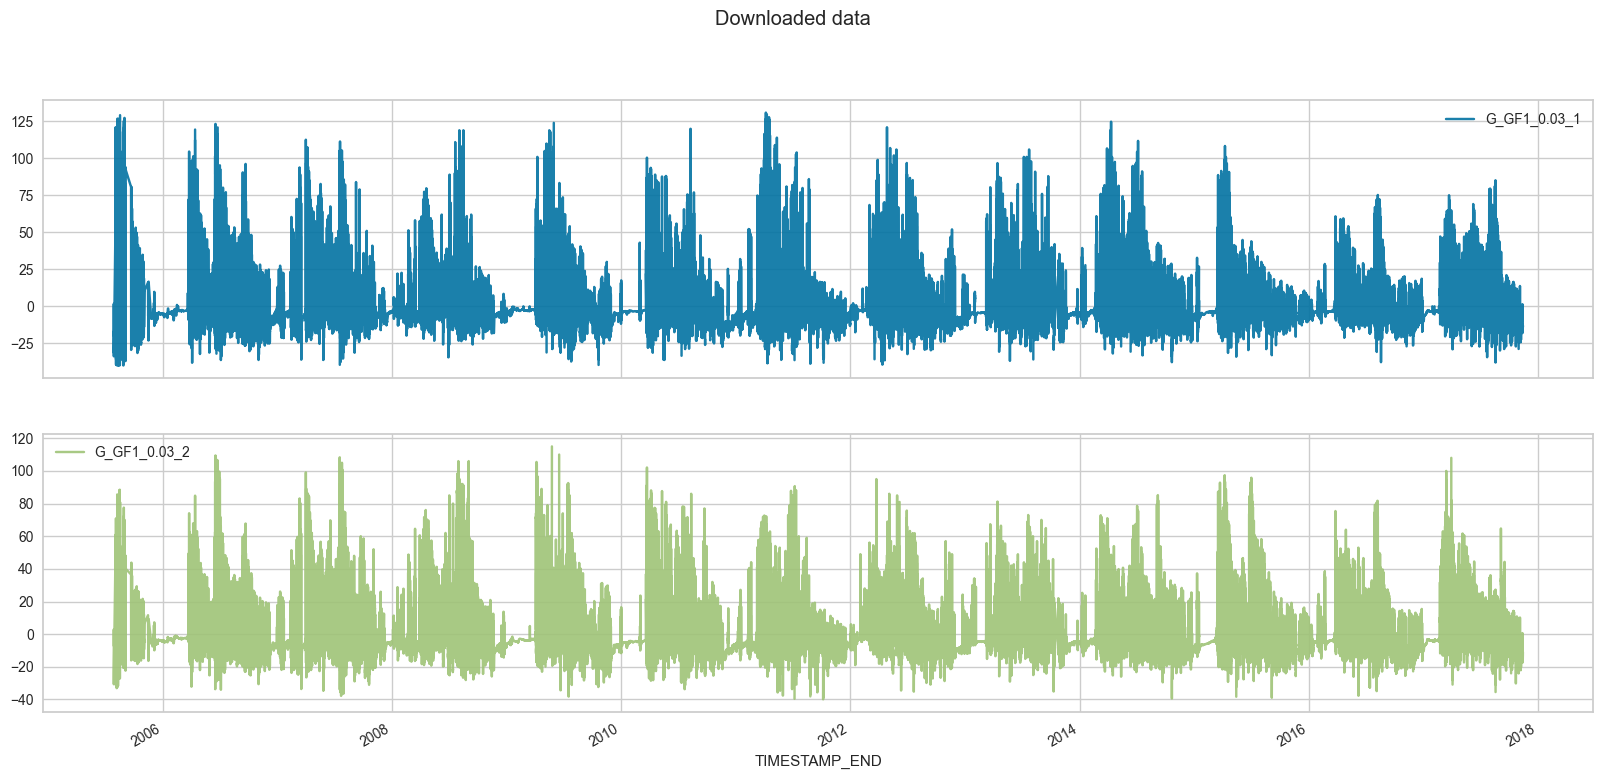

In [11]:
data_simple.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9);

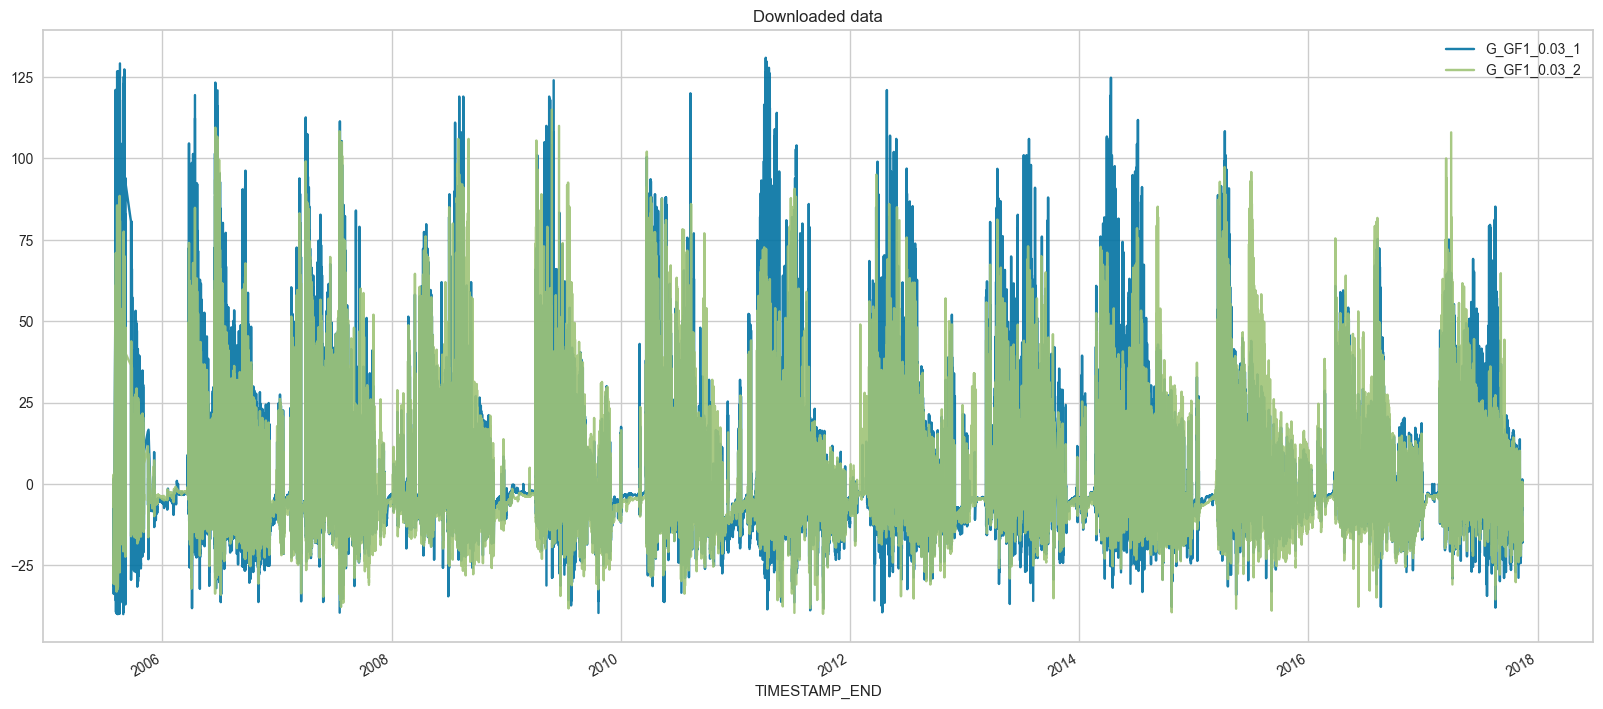

In [12]:
data_simple.plot(subplots=False, figsize=(20, 9), title="Downloaded data", alpha=.9);

## Heatmap

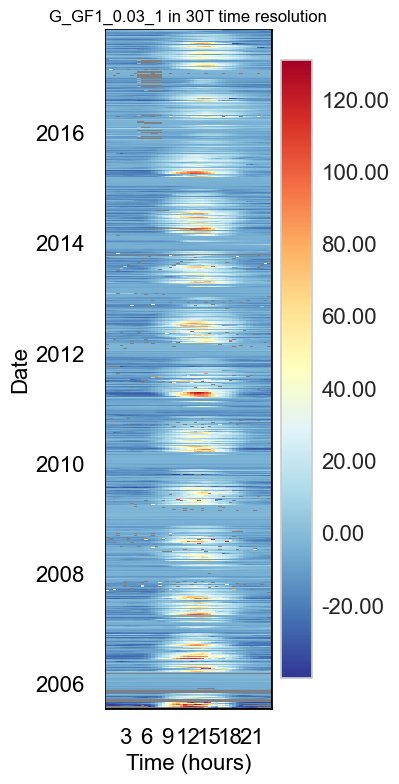

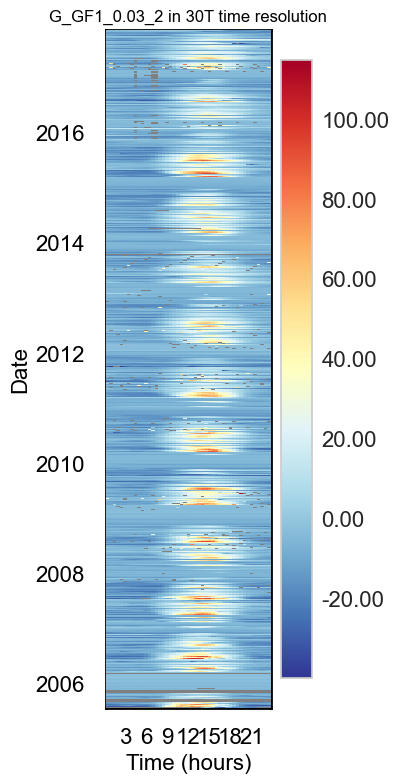

In [13]:
for col in data_simple.columns:    
    series = data_simple[col].asfreq('30T')
    HeatmapDateTime(series, figsize=(4,8)).show()    

## Stats

In [14]:
data_simple.describe()

,G_GF1_0.03_1,G_GF1_0.03_2
count,209700.000000,210241.000000
mean,-0.897971,-1.213773
std,15.743497,14.531478
min,-39.987000,-39.888000
25%,-9.099325,-9.148800
50%,-4.376950,-4.693600
75%,1.688800,1.848000
max,130.920000,115.000000


## Save to file

In [15]:
data_simple.to_csv(OUTFILE)

</br>

# **Prepare data for FLUXNET upload**

## Working data

In [16]:
wdf = data_simple.copy()

## Merge two precipitation variables into one time series

In [17]:
# wdf['PREC_TOT_T1+GF1_0.5+1_1'] = wdf['PREC_TOT_GF1_1_1'].combine_first(wdf['PREC_TOT_T1_0.5_1'])

In [18]:
# wdf[['PREC_TOT_T1_0.5_1', 'PREC_TOT_GF1_1_1', 'PREC_TOT_T1+GF1_0.5+1_1']].plot(subplots=True);

## Remove unneeded precipitation columns from data

In [19]:
# wdf = wdf.drop(['PREC_TOT_T1_0.5_1', 'PREC_TOT_GF1_1_1'], axis=1)
# wdf

## Set all missing values to -9999 as required by FLUXNET

In [20]:
wdf = wdf.fillna(-9999)

In [21]:
wdf.describe()

,G_GF1_0.03_1,G_GF1_0.03_2
count,212146.000000,212146.000000
mean,-116.174043,-90.990544
std,1067.475398,943.251055
min,-9999.000000,-9999.000000
25%,-9.339850,-9.324100
50%,-4.455600,-4.748500
75%,1.500350,1.699025
max,130.920000,115.000000


## Rename variables to FLUXNET-compliant variable names
- Using the same names as for previous upload
- For `PREC` we have two time series which were merged together

In [22]:
renaming_dict = {
    'G_GF1_0.03_1': 'G_1_1_1',
    'G_GF1_0.03_2': 'G_1_1_2'
}

In [23]:
wdf = wdf.rename(columns=renaming_dict)

In [24]:
wdf.describe()

,G_1_1_1,G_1_1_2
count,212146.000000,212146.000000
mean,-116.174043,-90.990544
std,1067.475398,943.251055
min,-9999.000000,-9999.000000
25%,-9.339850,-9.324100
50%,-4.455600,-4.748500
75%,1.500350,1.699025
max,130.920000,115.000000


## Insert additional timestamp columns
- FLUXNET needs both `TIMESTAMP_START` and `TIMESTAMP_END`

In [25]:
from diive.core.times.times import insert_timestamp, continuous_timestamp_freq
wdf = continuous_timestamp_freq(data=wdf, freq='30T')  # Make sure data are in 30MIN time resolution
wdf = insert_timestamp(data=wdf, convention='end', insert_as_first_col=True, verbose=True)
wdf = insert_timestamp(data=wdf, convention='start', insert_as_first_col=True, verbose=True)


Adding new timestamp column TIMESTAMP_END to show end of averaging period ...
    ++Added new timestamp column TIMESTAMP_END:
        first date: 2005-07-29 14:00:00
        last date:  2017-11-13 22:00:00
    The timestamp index was not changed:
        first date: 2005-07-29 14:00:00
        last date:  2017-11-13 22:00:00

Adding new timestamp column TIMESTAMP_START to show start of averaging period ...
    ++Added new timestamp column TIMESTAMP_START:
        first date: 2005-07-29 13:30:00
        last date:  2017-11-13 21:30:00
    The timestamp index was not changed:
        first date: 2005-07-29 14:00:00
        last date:  2017-11-13 22:00:00


In [26]:
wdf

,TIMESTAMP_START,TIMESTAMP_END,G_1_1_1,G_1_1_2
TIMESTAMP_END,,,,
2005-07-29 14:00:00,2005-07-29 13:30:00,2005-07-29 14:00:00,-19.8280,-7.1349
2005-07-29 14:30:00,2005-07-29 14:00:00,2005-07-29 14:30:00,1.6867,2.9131
2005-07-29 15:00:00,2005-07-29 14:30:00,2005-07-29 15:00:00,-8.2233,-2.4862
2005-07-29 15:30:00,2005-07-29 15:00:00,2005-07-29 15:30:00,-20.8860,-13.2020
2005-07-29 16:00:00,2005-07-29 15:30:00,2005-07-29 16:00:00,-31.3300,-22.1110
...,...,...,...,...
2017-11-13 20:00:00,2017-11-13 19:30:00,2017-11-13 20:00:00,-14.0400,-12.9300
2017-11-13 20:30:00,2017-11-13 20:00:00,2017-11-13 20:30:00,-13.4830,-12.3130
2017-11-13 21:00:00,2017-11-13 20:30:00,2017-11-13 21:00:00,-13.0440,-11.7850


## Reformat additional timestamp columns
- Needed in the format `YYYYMMDDhhmm`

In [27]:
from diive.core.times.times import format_timestamp_to_fluxnet_format
wdf['TIMESTAMP_END'] = format_timestamp_to_fluxnet_format(df=wdf, timestamp_col='TIMESTAMP_END')
wdf['TIMESTAMP_START'] = format_timestamp_to_fluxnet_format(df=wdf, timestamp_col='TIMESTAMP_START')
wdf


Formatting timestamp column TIMESTAMP_END to %Y%m%d%H%M ...

Formatting timestamp column TIMESTAMP_START to %Y%m%d%H%M ...


,TIMESTAMP_START,TIMESTAMP_END,G_1_1_1,G_1_1_2
TIMESTAMP_END,,,,
2005-07-29 14:00:00,200507291330,200507291400,-19.8280,-7.1349
2005-07-29 14:30:00,200507291400,200507291430,1.6867,2.9131
2005-07-29 15:00:00,200507291430,200507291500,-8.2233,-2.4862
2005-07-29 15:30:00,200507291500,200507291530,-20.8860,-13.2020
2005-07-29 16:00:00,200507291530,200507291600,-31.3300,-22.1110
...,...,...,...,...
2017-11-13 20:00:00,201711131930,201711132000,-14.0400,-12.9300
2017-11-13 20:30:00,201711132000,201711132030,-13.4830,-12.3130
2017-11-13 21:00:00,201711132030,201711132100,-13.0440,-11.7850


## Export to yearly files

In [28]:
# Convert timestamp index to TIMESTAMP_MIDDLE
from diive.core.times.times import TimestampSanitizer
wdf = TimestampSanitizer(data=wdf).get()
wdf

,TIMESTAMP_START,TIMESTAMP_END,G_1_1_1,G_1_1_2
TIMESTAMP_MIDDLE,,,,
2005-07-29 13:45:00,200507291330,200507291400,-19.8280,-7.1349
2005-07-29 14:15:00,200507291400,200507291430,1.6867,2.9131
2005-07-29 14:45:00,200507291430,200507291500,-8.2233,-2.4862
2005-07-29 15:15:00,200507291500,200507291530,-20.8860,-13.2020
2005-07-29 15:45:00,200507291530,200507291600,-31.3300,-22.1110
...,...,...,...,...
2017-11-13 19:45:00,201711131930,201711132000,-14.0400,-12.9300
2017-11-13 20:15:00,201711132000,201711132030,-13.4830,-12.3130
2017-11-13 20:45:00,201711132030,201711132100,-13.0440,-11.7850


### Export

In [29]:
# format like this: 'CH-FRU_2021_SWC_TS_PREC_G_20240302.csv'
SITE = 'CH-FRU'
RUNID = '20240302'

uniq_years = list(wdf.index.year.unique())
for year in uniq_years:
    outname = f"{SITE}_{year}_Meteo_{RUNID}.csv"    
    yearlocs = wdf.index.year == year
    yeardata = wdf[yearlocs].copy()
    yeardata.to_csv(outname, index=False)
    print(f"    --> Saved file {outname}.")

    --> Saved file CH-FRU_2005_Meteo_20240302.csv.
    --> Saved file CH-FRU_2006_Meteo_20240302.csv.
    --> Saved file CH-FRU_2007_Meteo_20240302.csv.
    --> Saved file CH-FRU_2008_Meteo_20240302.csv.
    --> Saved file CH-FRU_2009_Meteo_20240302.csv.
    --> Saved file CH-FRU_2010_Meteo_20240302.csv.
    --> Saved file CH-FRU_2011_Meteo_20240302.csv.
    --> Saved file CH-FRU_2012_Meteo_20240302.csv.
    --> Saved file CH-FRU_2013_Meteo_20240302.csv.
    --> Saved file CH-FRU_2014_Meteo_20240302.csv.
    --> Saved file CH-FRU_2015_Meteo_20240302.csv.
    --> Saved file CH-FRU_2016_Meteo_20240302.csv.
    --> Saved file CH-FRU_2017_Meteo_20240302.csv.


# End of notebook.

In [30]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-03-15 14:44:34
